## Feature set 2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import librosa
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import time
from keras.callbacks import EarlyStopping

from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,merge,Activation

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Using TensorFlow backend.


#### Extracting data from csv files into numpy arrays

In [2]:
#extracting data from csv files into numpy arrays
from numpy import genfromtxt
files_data=np.array(['fold_data_1.csv','fold_data_2.csv','fold_data_3.csv','fold_data_4.csv','fold_data_5.csv',
                'fold_data_6.csv','fold_data_7.csv','fold_data_8.csv','fold_data_9.csv','fold_data_10.csv'])
X_folds= np.array([genfromtxt(file,delimiter=',') for file in files_data])

files_label=(['fold_labels_1.csv','fold_labels_2.csv','fold_labels_3.csv','fold_labels_4.csv','fold_labels_5.csv',
                'fold_labels_6.csv','fold_labels_7.csv','fold_labels_8.csv','fold_labels_9.csv','fold_labels_10.csv'])
Y_folds= np.array([genfromtxt(file,delimiter=',') for file in files_label])

In [3]:
def data_processor_cnn(X_fold,Y_fold):
    X_fold_processor_cnn = [0]*10
    Y_fold_processor_cnn = [0]*10
    Y_fold_processor_cnn=([to_categorical(Y_fold, num_classes=10) for Y_fold in Y_fold])
    for i in range(0, len(X_fold)):
        X_fold_processor_cnn[i]=np.reshape(X_fold[i],(X_fold[i].shape[0], 24, 4, 1))
    return X_fold_processor_cnn,Y_fold_processor_cnn

In [4]:
def data_processor_basic_nn(X_fold,Y_fold):
    X_fold_basic_nn = [0]*10
    Y_fold_basic_nn = [0]*10
    for i in range(0, len(Y_fold)):
        Y_fold_basic_nn[i]=np.reshape(Y_fold[i],(Y_fold[i].shape[0], 1))
    for i in range(0, len(X_fold)):
        X_fold_basic_nn[i]=np.reshape(X_fold[i],(X_fold[i].shape[0], 24, 4))
    return X_fold_basic_nn,Y_fold_basic_nn

In [5]:
def data_processor_log_reg(X_fold,Y_fold):
    X_fold_log_reg = [0]*10
    Y_fold_log_reg = [0]*10
    for i in range(0, len(Y_fold)):
        Y_fold_log_reg[i]=np.reshape(Y_fold[i],(Y_fold[i].shape[0], 1))
    for i in range(0, len(X_fold)):
        X_fold_log_reg[i]=np.reshape(X_fold[i],(X_fold[i].shape[0], 96))
    return X_fold_log_reg,Y_fold_log_reg

In [6]:
Data_cnn=data_processor_cnn(X_folds,Y_folds)
X_folds_10=Data_cnn[0]
Y_folds_10=Data_cnn[1]

In [7]:
Data_nn=data_processor_basic_nn(X_folds,Y_folds)
X_folds_1=Data_nn[0]
Y_folds_1=Data_nn[1]

In [8]:
Data_Linear=data_processor_log_reg(X_folds,Y_folds)
X_folds_2=Data_Linear[0]
Y_folds_2=Data_Linear[1]

##### shapes of data

In [9]:
for i in range((10)):
    print("X_data",i+1,"=",np.shape(X_folds_10[i]))
    print("Y_data",i+1,"=",np.shape(Y_folds_10[i]))
    
for i in range((10)):
    print("X_data",i+1,"=",np.shape(X_folds_1[i]))
    print("Y_data",i+1,"=",np.shape(Y_folds_1[i]))

X_data 1 = (873, 24, 4, 1)
Y_data 1 = (873, 10)
X_data 2 = (888, 24, 4, 1)
Y_data 2 = (888, 10)
X_data 3 = (925, 24, 4, 1)
Y_data 3 = (925, 10)
X_data 4 = (990, 24, 4, 1)
Y_data 4 = (990, 10)
X_data 5 = (936, 24, 4, 1)
Y_data 5 = (936, 10)
X_data 6 = (823, 24, 4, 1)
Y_data 6 = (823, 10)
X_data 7 = (838, 24, 4, 1)
Y_data 7 = (838, 10)
X_data 8 = (806, 24, 4, 1)
Y_data 8 = (806, 10)
X_data 9 = (816, 24, 4, 1)
Y_data 9 = (816, 10)
X_data 10 = (837, 24, 4, 1)
Y_data 10 = (837, 10)
X_data 1 = (873, 24, 4)
Y_data 1 = (873, 1)
X_data 2 = (888, 24, 4)
Y_data 2 = (888, 1)
X_data 3 = (925, 24, 4)
Y_data 3 = (925, 1)
X_data 4 = (990, 24, 4)
Y_data 4 = (990, 1)
X_data 5 = (936, 24, 4)
Y_data 5 = (936, 1)
X_data 6 = (823, 24, 4)
Y_data 6 = (823, 1)
X_data 7 = (838, 24, 4)
Y_data 7 = (838, 1)
X_data 8 = (806, 24, 4)
Y_data 8 = (806, 1)
X_data 9 = (816, 24, 4)
Y_data 9 = (816, 1)
X_data 10 = (837, 24, 4)
Y_data 10 = (837, 1)


# Defining Functions
## Simple nn function

In [10]:

def Model_run_nn(model_history,model,X_folds,Y_folds,Accuracy_array,accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
             Fold_accuracy,Val_accuracy_array,Val_Loss_array, Confusion_Matrix_array, 
             Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy):
   
    fold=0
    for i in range(10):
        start = time.time()
        fold+=1
        print(f"\nFold #{fold}\n- - - - - - - - - - - - - - - - - - - -")

        x_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        x_test = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i==j])
        y_test = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i==j])
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
        model_history = model.fit(x_train,y_train,batch_size=Batch_size,epochs=Epoch_number,validation_data=(x_test,y_test)
                                  ,verbose=0)
        
        model_evaluation = model.evaluate(x_test, y_test, verbose = 0)
        score=model_evaluation[1]
        accuracy_score.append(score)
        
        # Generate confusion matrix
        y_pred = model.predict_classes(x_test)
        cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
        Confusion_Matrix_array.append(cm)
        
        # metrics
        f1 = sklearn.metrics.f1_score(y_test, y_pred, average='weighted')
        precision = sklearn.metrics.precision_score(y_test, y_pred, average='weighted')
        recall = sklearn.metrics.recall_score(y_test, y_pred, average='weighted')
        accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
        
        Metrics_f1.append(f1)
        Metrics_precision.append(precision)
        Metrics_recall.append(recall)
        Metrics_accuracy.append(accuracy)
        
        accuracy=model_history.history['accuracy']
        accuracy_avg=np.mean(accuracy)
        
        Fold_accuracy.append(accuracy_avg)
        print(f"Accuracy of Fold {fold} is {accuracy_avg}")
        end = time.time()
        print("Time to train Fold", fold,":",round(((end)- (start)),4),"seconds.")
        end_array.append(round(((end)- (start)),4))
        
    
        Epoch_array=model_history.history['accuracy']
        Epoch_array_accuracy.append(Epoch_array)
        loss=model_history.history['loss']
        Loss_array.append(loss)
    
        Epoch_val_array=model_history.history['val_accuracy']
        Val_accuracy_array.append(Epoch_val_array)
    
        loss_val=model_history.history['val_loss']
        Val_Loss_array.append(loss_val)
    
    Avg_Accuracy=np.mean(Fold_accuracy)       
    Time=sum(end_array)
    print("\n - - - - - - - - - - - - - - -\nThe average accuracy of the model:",(Avg_Accuracy))
    print("The time taken to run model:",Time)
    return Avg_Accuracy,Time

In [11]:
def Model_run_nn_es(model_history,model,X_folds,Y_folds,Accuracy_array,accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
             Fold_accuracy,Val_accuracy_array,Val_Loss_array, Confusion_Matrix_array,
             Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy):
    
    for i in range(0, len(X_folds)):
        X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 24, 4, 1))
    fold=0
    for i in range(10):
        start = time.time()
        fold+=1
        print(f"\nFold #{fold}\n- - - - - - - - - - - - - - - - - - - -")

        x_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        x_test = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i==j])
        y_test = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i==j])
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
        model_history = model.fit(x_train,y_train,epochs=Epoch_number,validation_data=(x_test,y_test)
                                  ,verbose=0, callbacks=[early_stopping_cb])
        
        model_evaluation = model.evaluate(x_test, y_test, verbose = 0)
        score=model_evaluation[1]
        accuracy_score.append(score)
        
        # Generate confusion matrix
        y_pred = model.predict_classes(x_test)
        # Reverse categorical y_test (used in CNN)
        y_test_a = np.argmax(y_test, axis=1)
#         print(y_test_a)
        cm = sklearn.metrics.confusion_matrix(y_test_a, y_pred)
        Confusion_Matrix_array.append(cm)
        
        # metrics
        f1 = sklearn.metrics.f1_score(y_test_a, y_pred, average='weighted')
        precision = sklearn.metrics.precision_score(y_test_a, y_pred, average='weighted')
        recall = sklearn.metrics.recall_score(y_test_a, y_pred, average='weighted')
        accuracy = sklearn.metrics.accuracy_score(y_test_a, y_pred)
        
        Metrics_f1.append(f1)
        Metrics_precision.append(precision)
        Metrics_recall.append(recall)
        Metrics_accuracy.append(accuracy)
        
        accuracy=model_history.history['accuracy']
        accuracy_avg=np.mean(accuracy)
        
        Fold_accuracy.append(accuracy_avg)
        print(f"Accuracy of Fold {fold} is {accuracy_avg}")
        end = time.time()
        print("Time to train Fold", fold,":",round(((end)- (start)),4),"seconds.")
        end_array.append(round(((end)- (start)),4))
        
    
        Epoch_array=model_history.history['accuracy']
        Epoch_array_accuracy.append(Epoch_array)
        loss=model_history.history['loss']
        Loss_array.append(loss)
    
        Epoch_val_array=model_history.history['val_accuracy']
        Val_accuracy_array.append(Epoch_val_array)
    
        loss_val=model_history.history['val_loss']
        Val_Loss_array.append(loss_val)
    
    Avg_Accuracy=np.mean(Fold_accuracy)       
    Time=sum(end_array)
    print("\n - - - - - - - - - - - - - - -\nThe average accuracy of the model:",(Avg_Accuracy))
    print("The time taken to run model:",Time)
    return Avg_Accuracy,Time

In [51]:
def Model_run_nn_es_NO_EARLY_STOPPING(model_history,model,X_folds,Y_folds,Accuracy_array,accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
             Fold_accuracy,Val_accuracy_array,Val_Loss_array, Confusion_Matrix_array,
             Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy):
    
    for i in range(0, len(X_folds)):
        X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 24, 4, 1))
    fold=0
    for i in range(10):
        start = time.time()
        fold+=1
        print(f"\nFold #{fold}\n- - - - - - - - - - - - - - - - - - - -")

        x_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i!=j])
        x_test = np.vstack([X_folds[j] for j in range(0, len(Y_folds)) if i==j])
        y_test = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)) if i==j])
        print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    
        model_history = model.fit(x_train,y_train,epochs=Epoch_number,validation_data=(x_test,y_test)
                                  ,verbose=0)
        
        model_evaluation = model.evaluate(x_test, y_test, verbose = 0)
        score=model_evaluation[1]
        accuracy_score.append(score)
        
        # Generate confusion matrix
        y_pred = model.predict_classes(x_test)
        # Reverse categorical y_test (used in CNN)
        y_test_a = np.argmax(y_test, axis=1)
#         print(y_test_a)
        cm = sklearn.metrics.confusion_matrix(y_test_a, y_pred)
        Confusion_Matrix_array.append(cm)
        
        # metrics
        f1 = sklearn.metrics.f1_score(y_test_a, y_pred, average='weighted')
        precision = sklearn.metrics.precision_score(y_test_a, y_pred, average='weighted')
        recall = sklearn.metrics.recall_score(y_test_a, y_pred, average='weighted')
        accuracy = sklearn.metrics.accuracy_score(y_test_a, y_pred)
        
        Metrics_f1.append(f1)
        Metrics_precision.append(precision)
        Metrics_recall.append(recall)
        Metrics_accuracy.append(accuracy)
        
        accuracy=model_history.history['accuracy']
        accuracy_avg=np.mean(accuracy)
        
        Fold_accuracy.append(accuracy_avg)
        print(f"Accuracy of Fold {fold} is {accuracy_avg}")
        end = time.time()
        print("Time to train Fold", fold,":",round(((end)- (start)),4),"seconds.")
        end_array.append(round(((end)- (start)),4))
        
    
        Epoch_array=model_history.history['accuracy']
        Epoch_array_accuracy.append(Epoch_array)
        loss=model_history.history['loss']
        Loss_array.append(loss)
    
        Epoch_val_array=model_history.history['val_accuracy']
        Val_accuracy_array.append(Epoch_val_array)
    
        loss_val=model_history.history['val_loss']
        Val_Loss_array.append(loss_val)
    
    Avg_Accuracy=np.mean(Fold_accuracy)       
    Time=sum(end_array)
    print("\n - - - - - - - - - - - - - - -\nThe average accuracy of the model:",(Avg_Accuracy))
    print("The time taken to run model:",Time)
    return Avg_Accuracy,Time

### Graph function

In [13]:
def Graph_func(Epoch_number,Epoch_array_accuracy,Val_accuracy_array,Loss_array,val_loss_array):
    %matplotlib inline
    
    fig,ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig.suptitle(f"Accuracy of each Epoch for each Fold")
    ax1.set_xlabel("Epoch number")
    ax1.set_ylabel("Accuracy")
    ax1.grid()
    for i in range(10):
        ax1.plot(Epoch_array_accuracy[i],label=('Fold',i+1))
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    
    fig,ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig.suptitle(f"Accuracy of each Epoch for each Fold")
    ax1.set_xlabel("Epoch number")
    ax1.set_ylabel("Val Accuracy")
    ax1.grid()
    for i in range(10):
        ax1.plot(Val_accuracy_array[i],label=('Fold',i+1))
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    fig1,ax2 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig1.suptitle(f"Loss of each Epoch for each Fold")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.grid()
    for i in range(10):
        ax2.plot(Loss_array[i],label=('Fold',i+1))
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))    
    
    fig1,ax2 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    fig1.suptitle(f"Val Loss of each Epoch for each Fold")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Val Loss")
    ax2.grid()
    for i in range(10):
        ax2.plot(val_loss_array[i],label=('Fold',i+1))
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))   

### Table function

In [14]:
def table_maker(Fold_accuracy,end_array,Avg_Accuracy,Time):
    data= {'Fold': ['1','2','3','4','5','6','7','8','9','10'],
           'Accuracy': [Fold_accuracy[0],Fold_accuracy[1],Fold_accuracy[2],Fold_accuracy[3],Fold_accuracy[4],
                    Fold_accuracy[5],Fold_accuracy[6],Fold_accuracy[7],Fold_accuracy[8],Fold_accuracy[9]],
           'Time Taken' :[end_array[0],end_array[1],end_array[2],end_array[3],end_array[4],end_array[5],end_array[6],end_array[7],
                end_array[8],end_array[9]]}
    df = pd.DataFrame(data, columns = ['Fold', 'Accuracy','Time Taken'])
    data_avg={'Average Accuracy':[Avg_Accuracy],'Total Time':[Time]}
    df_avg=pd.DataFrame(data_avg,columns=['Average Accuracy','Total Time'])
    print (df)
    print ("\n",df_avg)

### Average graph function

In [15]:
def Graph_Avg_maker(Fold_accuracy,Avg_Accuracy):
    %matplotlib inline
    Fold_iteration=np.linspace(1,10,num=10)
    fig, ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())
    ax1.plot(Fold_iteration,Fold_accuracy,"gx")
    ax1.axhline(y=Avg_Accuracy,label='Average Accuracy')
    fig.suptitle(f"Results for Batch size of {Batch_size}\n and Epoch number of {Epoch_number}\n for Feature set 1")
    ax1.set_xlabel("Fold iteration")
    ax1.set_ylabel("Accuracy")
    ax1.grid()
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Confusion matrix function

In [16]:
import sklearn
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def Confusion_matrix(x_test, y_test_a, model=None):

    if model == None:
        return 'Please pass a defined model to this function'
    
    # Create predictions
    try:
        y_test_pred = model.predict_classes(x_test)
    except:
        y_test_pred = model.predict(x_test)
    
    # Read file with the defined classes (should be available in every folder)
    classes = pd.read_csv("classes.csv")
    classes = classes['class'].tolist()
    
    # Create confusion matrix
    array = sklearn.metrics.confusion_matrix(y_test_a, y_test_pred)

    axis_labels = classes # labels for x and y axis

    # create seaborn heatmap with required labels
    plt.figure(figsize = (12, 10))
    sn.heatmap(array, annot=True, xticklabels=axis_labels, yticklabels=axis_labels)
    # fixing axis that are cut otherwise
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    plt.show()

In [17]:
def plot_confusion_matrix(cm):
    
    # Read file with the defined classes (should be available in every folder)
    classes = pd.read_csv("classes.csv")
    classes = classes['class'].tolist()
    
    # Read confusion matrix
    array = cm

    axis_labels = classes # labels for x and y axis

    # create seaborn heatmap with required labels
    plt.figure(figsize = (12, 10))
    sn.heatmap(array, annot=True, xticklabels=axis_labels, yticklabels=axis_labels)
    # fixing axis that are cut otherwise
    b, t = plt.ylim()
    b += 0.5
    t -= 0.5
    plt.ylim(b, t)
    plt.show()

In [18]:
def average_confusion_matrix(X):
    # Returns the average confusion matrix for the 10-fold cross-validation results
    avg_cm = (X[0]+X[1]+X[2]+X[3]+X[4]+X[5]+X[6]+X[7]+X[8]+X[9])
    return avg_cm

## Model 1

In [19]:
model=Sequential()
model.add(Flatten(input_shape=[24, 4]))
model.add(Dense(300, activation="relu"))   
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="softmax"))
Model=model.compile(loss = "sparse_categorical_crossentropy", optimizer="adam", metrics = ["accuracy"])

In [20]:
Accuracy_array=[]
accuracy_total=0
end_array=[]
Epoch_array_accuracy=[]
Loss_array=[]
Fold_accuracy=[]
Val_accuracy_array=[]
Val_Loss_array_1=[]
Avg_Accuracy=[]
Time=[]
accuracy_score=[]
Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Epoch_number=50
Batch_size=30

Model=Model_run_nn(Model,model,X_folds_1,Y_folds_1,Accuracy_array,
                   accuracy_total,end_array,Epoch_array_accuracy,Loss_array,
                   Fold_accuracy,Val_accuracy_array,Val_Loss_array_1, Confusion_Matrix_array,
                   Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)

Avg_Accuracy=Model[0]
Time=Model[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 24, 4) (7859, 1) (873, 24, 4) (873, 1)


C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of Fold 1 is 0.2614378333091736
Time to train Fold 1 : 35.5607 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 24, 4) (7844, 1) (888, 24, 4) (888, 1)
Accuracy of Fold 2 is 0.1846710741519928
Time to train Fold 2 : 36.0517 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 24, 4) (7807, 1) (925, 24, 4) (925, 1)
Accuracy of Fold 3 is 0.19591903686523438
Time to train Fold 3 : 40.3409 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 24, 4) (7742, 1) (990, 24, 4) (990, 1)
Accuracy of Fold 4 is 0.18917851150035858
Time to train Fold 4 : 38.5834 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 24, 4) (7796, 1) (936, 24, 4) (936, 1)
Accuracy of Fold 5 is 0.18013854324817657
Time to train Fold 5 : 30.3159 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 24, 4) (7909, 1) (823, 24, 4) (823, 1)
Accuracy of Fold 6 is 0.19474777579307556
Time to train Fold 6 : 40.4035 seconds.

Fold #7
- - - - - - - - - - - - - 

In [21]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.11220243636850756, 0.29983874125961113, 0.19473081328751432, 0.19473081328751432
2, 0.08921386068768888, 0.1772855198152312, 0.16441441441441443, 0.16441441441441443
3, 0.16174633688952936, 0.31185585585585585, 0.21621621621621623, 0.21621621621621623
4, 0.1751135971670717, 0.2687941973907509, 0.23232323232323232, 0.23232323232323232
5, 0.09227720080188999, 0.20221576619547307, 0.15705128205128205, 0.15705128205128205
6, 0.1080846322246382, 0.294733001758947, 0.15674362089914945, 0.15674362089914945
7, 0.050134017618642175, 0.21096100570059798, 0.10978520286396182, 0.10978520286396182
8, 0.13908470662390124, 0.2559274826555933, 0.184863523573201, 0.184863523573201
9, 0.15962438780892896, 0.26012464214335873, 0.2107843137254902, 0.2107843137254902
10, 0.050256463262537056, 0.2236211578147062, 0.12903225806451613, 0.12903225806451613


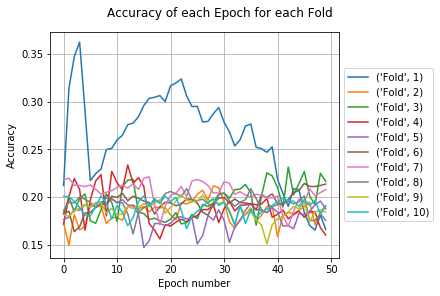

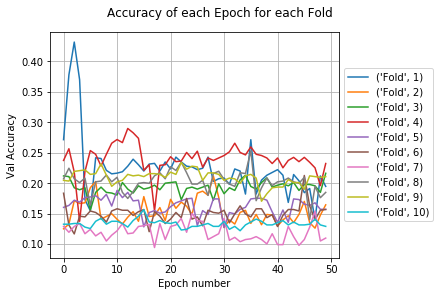

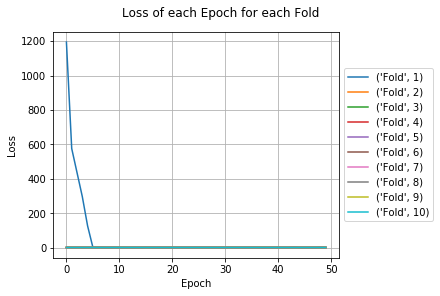

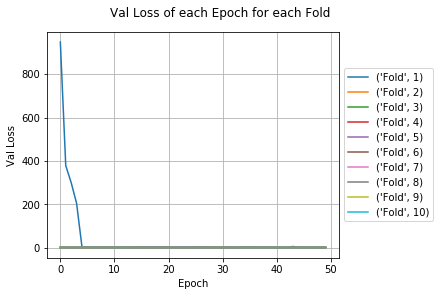

In [22]:
Graph_Epochs_model_1=Graph_func(Epoch_number,Epoch_array_accuracy,Val_accuracy_array,Loss_array,Val_Loss_array_1)

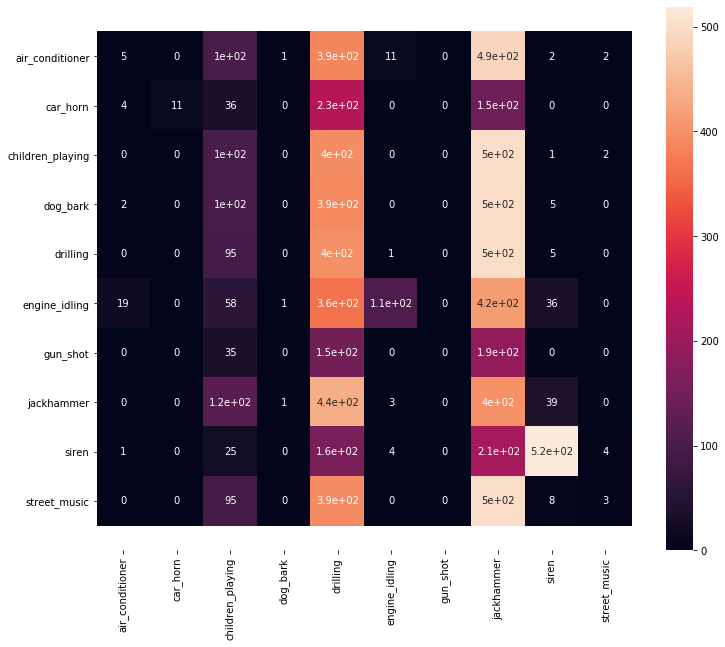

In [23]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [24]:
Table_model_1=table_maker(Fold_accuracy,end_array,Avg_Accuracy,Time)

  Fold  Accuracy  Time Taken
0    1  0.261438     35.5607
1    2  0.184671     36.0517
2    3  0.195919     40.3409
3    4  0.189179     38.5834
4    5  0.180139     30.3159
5    6  0.194748     40.4035
6    7  0.204773     34.1272
7    8  0.193174     24.1412
8    9  0.186819     27.2726
9   10  0.189429     30.6284

    Average Accuracy  Total Time
0          0.198029    337.4255


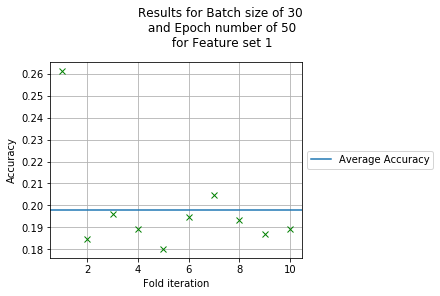

In [25]:
Graph_Avg_model_1=Graph_Avg_maker(Fold_accuracy,Avg_Accuracy)

### Model 1 no cross validation

In [26]:
for i in range(0, len(X_folds)):
    X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 24, 4))

X_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)-1)])
y_train = np.vstack([Y_folds_1[j] for j in range(0, len(Y_folds_1)-1)])
X_test = X_folds[9]
y_test = Y_folds[9]

Epoch_number=30

#compile model using accuracy to measure model performance
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#train the model
cnn_model_history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_1_no_cross=model.evaluate(X_test, y_test)
accuracy_model_1_no_cross = score_model_1_no_cross[1]
print(f"\nAccuracy of model 1 with no cross validation: {round(accuracy_model_1_no_cross,3)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 0s - loss: 2.1303 - accuracy: 0.15 - ETA: 0s - loss: 2.1277 - accuracy: 0.17 - ETA: 0s - loss: 2.1138 - accuracy: 0.18 - ETA: 0s - loss: 2.1179 - accuracy: 0.17 - ETA: 0s - loss: 2.1132 - accuracy: 0.17 - ETA: 0s - loss: 2.1090 - accuracy: 0.17 - ETA: 0s - loss: 2.0983 - accuracy: 0.17 - ETA: 0s - loss: 2.1245 - accuracy: 0.17 - 0s 48us/step - loss: 2.1239 - accuracy: 0.1782 - val_loss: 2.2318 - val_accuracy: 0.1254
Epoch 2/30
7895/7895 [==============================] - ETA: 0s - loss: 2.2756 - accuracy: 0.21 - ETA: 0s - loss: 2.0822 - accuracy: 0.19 - ETA: 0s - loss: 2.0885 - accuracy: 0.18 - ETA: 0s - loss: 2.1019 - accuracy: 0.18 - ETA: 0s - loss: 2.1037 - accuracy: 0.18 - ETA: 0s - loss: 2.0988 - accuracy: 0.18 - ETA: 0s - loss: 2.0975 - accuracy: 0.18 - 0s 43us/step - loss: 2.0974 - accuracy: 0.1813 - val_loss: 2.2199 - val_accuracy: 0.1290
Epoch 3/30
7895/7895 [===========

## Model 2

In [27]:
#adding layers and forming the model_1
#forming model_1
model_2=Sequential()
early_stopping_cb = EarlyStopping(patience=16, restore_best_weights=True)

    #add model layers
model_2.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(24,4,1)))
#model_2.add(Conv2D(32, kernel_size=3, activation='relu'))
model_2.add(Flatten())
model_2.add(Dense(10, activation='softmax'))
    #compile model using accuracy to measure model performance
Model_2=model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
Accuracy_array_2=[]
accuracy_total_2=0
end_array_2=[]

Epoch_array_accuracy_2=[]
Loss_array_2=[]
Fold_accuracy_2=[]

Val_accuracy_array_2=[]
Val_Loss_array_2=[]

Avg_Accuracy_2=[]
Time_2=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_2=Model_run_nn_es(Model_2,model_2,X_folds_10,Y_folds_10,Accuracy_array_2,
                     accuracy_total_2,end_array_2,Epoch_array_accuracy_2,Loss_array_2,
                     Fold_accuracy_2,Val_accuracy_array_2,Val_Loss_array_2, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_2=Model_2[0]
Time_2=Model_2[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 24, 4, 1) (7859, 10) (873, 24, 4, 1) (873, 10)
Accuracy of Fold 1 is 0.8265606164932251
Time to train Fold 1 : 50.529 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 24, 4, 1) (7844, 10) (888, 24, 4, 1) (888, 10)
Accuracy of Fold 2 is 0.9495715498924255
Time to train Fold 2 : 23.6357 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 24, 4, 1) (7807, 10) (925, 24, 4, 1) (925, 10)
Accuracy of Fold 3 is 0.953937292098999
Time to train Fold 3 : 16.862 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 24, 4, 1) (7742, 10) (990, 24, 4, 1) (990, 10)
Accuracy of Fold 4 is 0.956916093826294
Time to train Fold 4 : 18.7649 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 24, 4, 1) (7796, 10) (936, 24, 4, 1) (936, 10)
Accuracy of Fold 5 is 0.9555880427360535
Time to train Fold 5 : 17.5328 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 24, 4, 1) (7909, 10) (823, 2

In [29]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
0, 0.5848089192520228, 0.6314079987221234, 0.6036655211912944, 0.6036655211912944
1, 0.8775244938596706, 0.884278043740939, 0.8795045045045045, 0.8795045045045045
2, 0.8830274675741258, 0.8848563880911094, 0.8832432432432432, 0.8832432432432432
3, 0.9175992027560905, 0.9277054977731554, 0.9171717171717172, 0.9171717171717172
4, 0.9116056991108039, 0.915451384676964, 0.9123931623931624, 0.9123931623931624
5, 0.9176508271631909, 0.920308454120215, 0.9173754556500607, 0.9173754556500607
6, 0.929992227948672, 0.9329568334521205, 0.9295942720763724, 0.9295942720763724
7, 0.9463864344474135, 0.9483101012440023, 0.9466501240694789, 0.9466501240694789
8, 0.9224473538312434, 0.9259920576151474, 0.9227941176470589, 0.9227941176470589
9, 0.9701928686285141, 0.9707446469580414, 0.970131421744325, 0.970131421744325


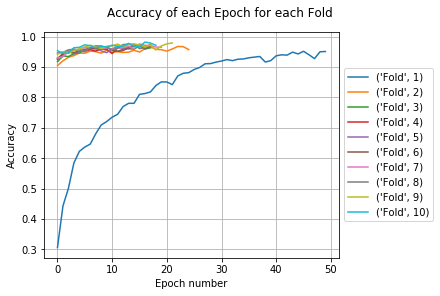

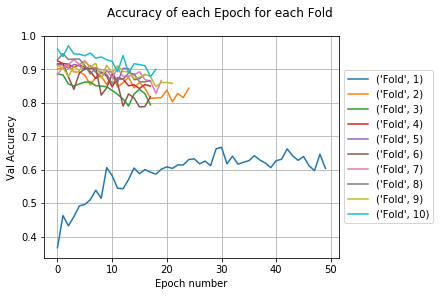

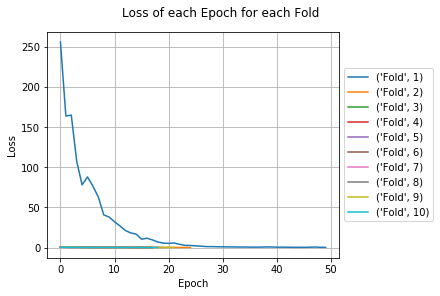

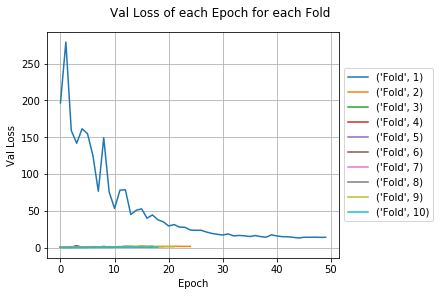

In [30]:
Graph_Epochs_model_2=Graph_func(Epoch_number,Epoch_array_accuracy_2,Val_accuracy_array_2,Loss_array_2,Val_Loss_array_2)

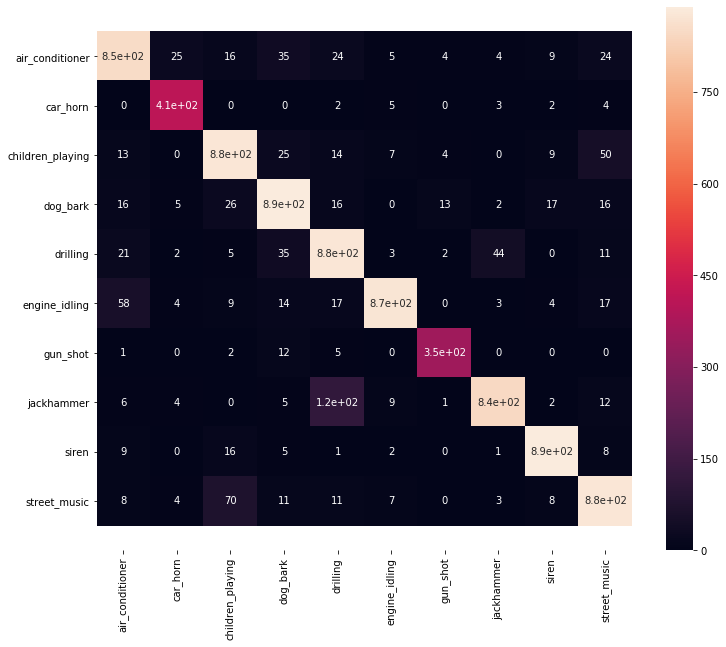

In [31]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [32]:
Table_model_2=table_maker(Fold_accuracy_2,end_array_2,Avg_Accuracy_2,Time_2)

  Fold  Accuracy  Time Taken
0    1  0.826561     50.5290
1    2  0.949572     23.6357
2    3  0.953937     16.8620
3    4  0.956916     18.7649
4    5  0.955588     17.5328
5    6  0.957425     16.8373
6    7  0.960768     18.7699
7    8  0.962634     17.9311
8    9  0.965501     22.8186
9   10  0.966914     18.3295

    Average Accuracy  Total Time
0          0.945582    222.0108


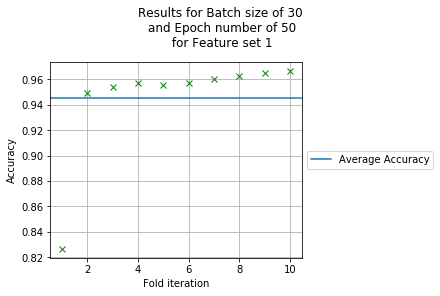

In [33]:
Graph_Avg_model_2=Graph_Avg_maker(Fold_accuracy_2,Avg_Accuracy_2)

### Model 2 no cross validation

In [34]:
for i in range(0, len(X_folds)):
    X_folds[i]=np.reshape(X_folds[i],(X_folds[i].shape[0], 24, 4,1))

Epoch_number=30
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

cnn_model_2_history = model_2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_2_no_cross=model_2.evaluate(X_test, y_test)
accuracy_model_2_no_cross = score_model_2_no_cross[1]
print(f"\nAccuracy of model 2 with no cross validation: {round(accuracy_model_2_no_cross,3)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 0s - loss: 0.2109 - accuracy: 0.93 - ETA: 0s - loss: 0.1589 - accuracy: 0.95 - ETA: 0s - loss: 0.1960 - accuracy: 0.95 - ETA: 0s - loss: 0.2047 - accuracy: 0.95 - ETA: 0s - loss: 0.2696 - accuracy: 0.95 - ETA: 0s - loss: 0.2793 - accuracy: 0.94 - ETA: 0s - loss: 0.2591 - accuracy: 0.95 - ETA: 0s - loss: 0.2530 - accuracy: 0.95 - ETA: 0s - loss: 0.2325 - accuracy: 0.95 - ETA: 0s - loss: 0.2297 - accuracy: 0.95 - ETA: 0s - loss: 0.2198 - accuracy: 0.95 - ETA: 0s - loss: 0.2238 - accuracy: 0.95 - 1s 77us/step - loss: 0.2202 - accuracy: 0.9560 - val_loss: 0.4755 - val_accuracy: 0.9307
Epoch 2/30
7895/7895 [==============================] - ETA: 0s - loss: 0.0656 - accuracy: 0.96 - ETA: 0s - loss: 0.4425 - accuracy: 0.94 - ETA: 0s - loss: 0.4339 - accuracy: 0.94 - ETA: 0s - loss: 0.3782 - accuracy: 0.94 - ETA: 0s - loss: 0.3755 - accuracy: 0.94 - ETA: 0s - loss: 0.3546 - accuracy: 0.9

## Model 3

In [35]:
model_3=Sequential()
early_stopping_cb = EarlyStopping(patience=17, restore_best_weights=True)

model_3.add(Conv2D(32,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(24,4,1)))
model_3.add(MaxPooling2D(padding="same"))

model_3.add(Conv2D(64,kernel_size=5,strides=1,padding="same",activation="relu"))
model_3.add(MaxPooling2D(padding="same"))
model_3.add(Dropout(0.2))

model_3.add(Flatten())

model_3.add(Dense(128,activation="relu"))
model_3.add(Dropout(0.2))

model_3.add(Dense(10,activation="softmax"))

    #compiling
Model_3=model_3.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [36]:
accuracy_total_3=0
end_array_3=[]

Epoch_array_accuracy_3=[]
Loss_array_3=[]
Fold_accuracy_3=[]

Val_accuracy_array_3=[]
Val_Loss_array_3=[]

Accuracy_array_3=[]
Avg_Accuracy_3=[]
Time_3=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_3=Model_run_nn_es(Model_3,model_3,X_folds_10,Y_folds_10,Accuracy_array_3,
                     accuracy_total_3,end_array_3,Epoch_array_accuracy_3,Loss_array_3,
                     Fold_accuracy_3,Val_accuracy_array_3,Val_Loss_array_3, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_3=Model_3[0]
Time_3=Model_3[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 24, 4, 1) (7859, 10) (873, 24, 4, 1) (873, 10)
Accuracy of Fold 1 is 0.4815268814563751
Time to train Fold 1 : 156.7818 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 24, 4, 1) (7844, 10) (888, 24, 4, 1) (888, 10)
Accuracy of Fold 2 is 0.5968772172927856
Time to train Fold 2 : 27.9472 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 24, 4, 1) (7807, 10) (925, 24, 4, 1) (925, 10)
Accuracy of Fold 3 is 0.7947141528129578
Time to train Fold 3 : 33.0919 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 24, 4, 1) (7742, 10) (990, 24, 4, 1) (990, 10)
Accuracy of Fold 4 is 0.7976298332214355
Time to train Fold 4 : 34.2478 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 24, 4, 1) (7796, 10) (936, 24, 4, 1) (936, 10)
Accuracy of Fold 5 is 0.7927356362342834
Time to train Fold 5 : 29.8586 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 24, 4, 1) (7909, 10) (8

In [37]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.5908578616704925, 0.6192759857932454, 0.5853379152348225, 0.5853379152348225
2, 0.7823962721176951, 0.7919193869959815, 0.7826576576576577, 0.7826576576576577
3, 0.8059642847273102, 0.8164041453876276, 0.8064864864864865, 0.8064864864864865
4, 0.8155763626580903, 0.8249686742192582, 0.8212121212121212, 0.8212121212121212
5, 0.8819452834652844, 0.8844317513232809, 0.8835470085470085, 0.8835470085470085
6, 0.816275442282816, 0.828417064997822, 0.8153098420413123, 0.8153098420413123
7, 0.8944694635541361, 0.8991614191054654, 0.8949880668257757, 0.8949880668257757
8, 0.7861390750439089, 0.7884715282527166, 0.7878411910669976, 0.7878411910669976
9, 0.8339130652115894, 0.8459568544536062, 0.8345588235294118, 0.8345588235294118
10, 0.854765185229567, 0.8632842228320045, 0.8554360812425329, 0.8554360812425329


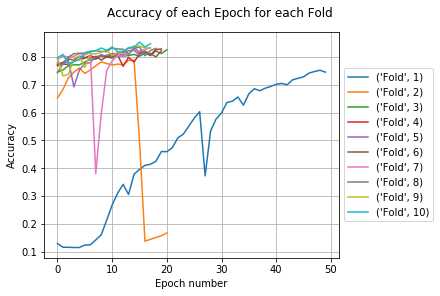

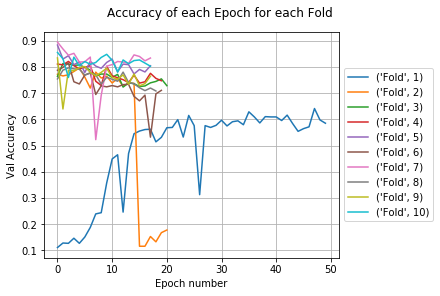

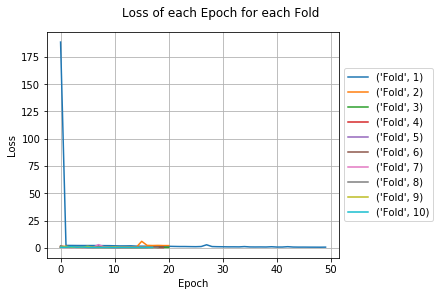

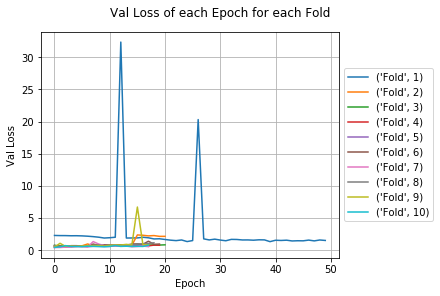

In [38]:
Graph_Epochs_model_3=Graph_func(Epoch_number,Epoch_array_accuracy_3,Val_accuracy_array_3,Loss_array_3,Val_Loss_array_3)

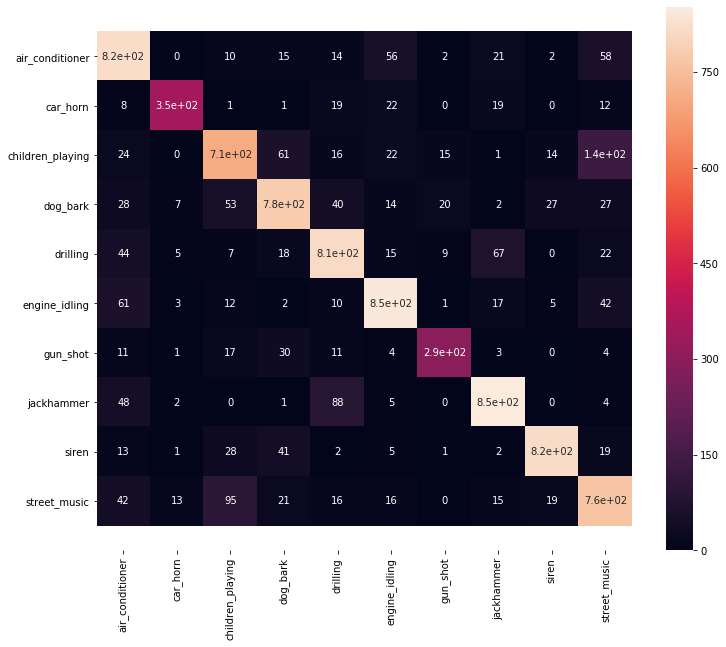

In [39]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [40]:
Table_model_3=table_maker(Fold_accuracy_3,end_array_3,Avg_Accuracy_3,Time_3)

  Fold  Accuracy  Time Taken
0    1  0.481527    156.7818
1    2  0.596877     27.9472
2    3  0.794714     33.0919
3    4  0.797630     34.2478
4    5  0.792736     29.8586
5    6  0.804539     32.4511
6    7  0.770846     28.9823
7    8  0.813870     30.9216
8    9  0.805984     28.6616
9   10  0.819576     28.7217

    Average Accuracy  Total Time
0           0.74783    431.6656


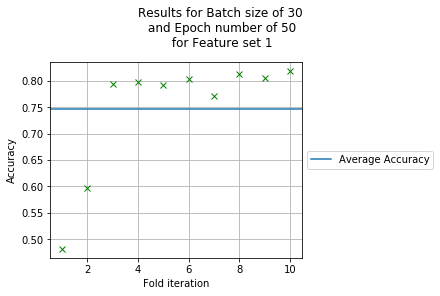

In [41]:
Graph_Avg_model_3=Graph_Avg_maker(Fold_accuracy_3,Avg_Accuracy_3)

### Model 3 no cross validation

In [42]:
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

Epoch_number=30
cnn_model_3_history = model_3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_3_no_cross=model_3.evaluate(X_test, y_test)
accuracy_model_3_no_cross = score_model_3_no_cross[1]
print(f"\nAccuracy of model 3 with no cross validation: {round(accuracy_model_3_no_cross,3)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 1s - loss: 0.6233 - accuracy: 0.78 - ETA: 1s - loss: 0.5327 - accuracy: 0.81 - ETA: 1s - loss: 0.4988 - accuracy: 0.82 - ETA: 1s - loss: 0.5541 - accuracy: 0.81 - ETA: 1s - loss: 0.5520 - accuracy: 0.81 - ETA: 1s - loss: 0.5660 - accuracy: 0.81 - ETA: 1s - loss: 0.5699 - accuracy: 0.81 - ETA: 1s - loss: 0.5761 - accuracy: 0.81 - ETA: 1s - loss: 0.5745 - accuracy: 0.81 - ETA: 1s - loss: 0.5782 - accuracy: 0.81 - ETA: 1s - loss: 0.5807 - accuracy: 0.81 - ETA: 1s - loss: 0.5824 - accuracy: 0.80 - ETA: 1s - loss: 0.5801 - accuracy: 0.80 - ETA: 1s - loss: 0.5818 - accuracy: 0.80 - ETA: 0s - loss: 0.5821 - accuracy: 0.80 - ETA: 0s - loss: 0.5828 - accuracy: 0.80 - ETA: 0s - loss: 0.5848 - accuracy: 0.80 - ETA: 0s - loss: 0.5858 - accuracy: 0.80 - ETA: 0s - loss: 0.5921 - accuracy: 0.80 - ETA: 0s - loss: 0.5854 - accuracy: 0.80 - ETA: 0s - loss: 0.5888 - accuracy: 0.80 - ETA: 0s - loss:

## Model 4

In [52]:
#adding layers and forming the model_1
#forming model_1
model_4=Sequential()

model_4.add(Conv2D(64,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(24,4,1)))
model_4.add(MaxPooling2D(padding="same"))

model_4.add(Flatten())

model_4.add(Dense(10,activation="softmax"))
#compiling
Model_4=model_4.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [53]:
Accuracy_array_4=[]
accuracy_total_4=0
end_array_4=[]

Epoch_array_accuracy_4=[]
Loss_array_4=[]
Fold_accuracy_4=[]

Val_accuracy_array_4=[]
Val_Loss_array_4=[]

Avg_Accuracy_4=[]
Time_4=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_4=Model_run_nn_es_NO_EARLY_STOPPING(Model_4,model_4,X_folds_10,Y_folds_10,Accuracy_array_4,
                     accuracy_total_4,end_array_4,Epoch_array_accuracy_4,Loss_array_4,
                     Fold_accuracy_4,Val_accuracy_array_4,Val_Loss_array_4, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_4=Model_4[0]
Time_4=Model_4[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 24, 4, 1) (7859, 10) (873, 24, 4, 1) (873, 10)
Accuracy of Fold 1 is 0.7230488657951355
Time to train Fold 1 : 77.9157 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 24, 4, 1) (7844, 10) (888, 24, 4, 1) (888, 10)
Accuracy of Fold 2 is 0.904171347618103
Time to train Fold 2 : 82.481 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 24, 4, 1) (7807, 10) (925, 24, 4, 1) (925, 10)
Accuracy of Fold 3 is 0.9337978959083557
Time to train Fold 3 : 79.5917 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 24, 4, 1) (7742, 10) (990, 24, 4, 1) (990, 10)
Accuracy of Fold 4 is 0.9460784792900085
Time to train Fold 4 : 81.1653 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 24, 4, 1) (7796, 10) (936, 24, 4, 1) (936, 10)
Accuracy of Fold 5 is 0.9560415744781494
Time to train Fold 5 : 79.4659 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 24, 4, 1) (7909, 10) (823,

In [54]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.6019240206842145, 0.6280411833535816, 0.6116838487972509, 0.6116838487972509
2, 0.71068710589039, 0.7413878604049418, 0.713963963963964, 0.713963963963964
3, 0.7375767447590603, 0.752777144765081, 0.7383783783783784, 0.7383783783783784
4, 0.8318282180671516, 0.8424306994826224, 0.8313131313131313, 0.8313131313131313
5, 0.8450051024467403, 0.8590992118204176, 0.842948717948718, 0.842948717948718
6, 0.8180105019270898, 0.8352744727697822, 0.818955042527339, 0.818955042527339
7, 0.8676052340070649, 0.8773125131673104, 0.8687350835322196, 0.8687350835322196
8, 0.8442565441131147, 0.8706684324318505, 0.8523573200992556, 0.8523573200992556
9, 0.8835053327984179, 0.8913531233093014, 0.883578431372549, 0.883578431372549
10, 0.9251249895903286, 0.9293423516904249, 0.9247311827956989, 0.9247311827956989


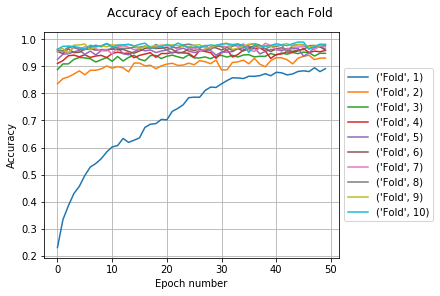

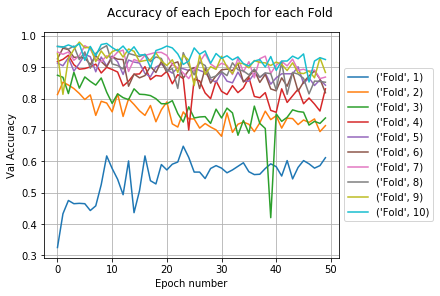

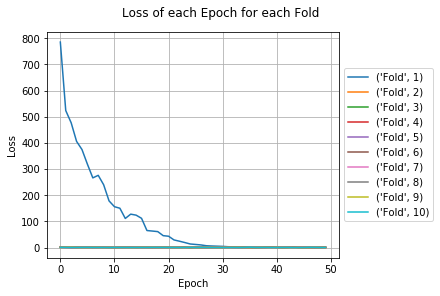

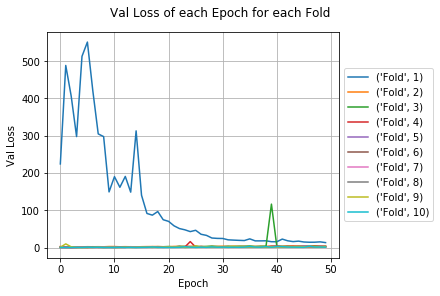

In [55]:
Graph_Epochs_model_4=Graph_func(Epoch_number,Epoch_array_accuracy_4,Val_accuracy_array_4,Loss_array_4,Val_Loss_array_4)

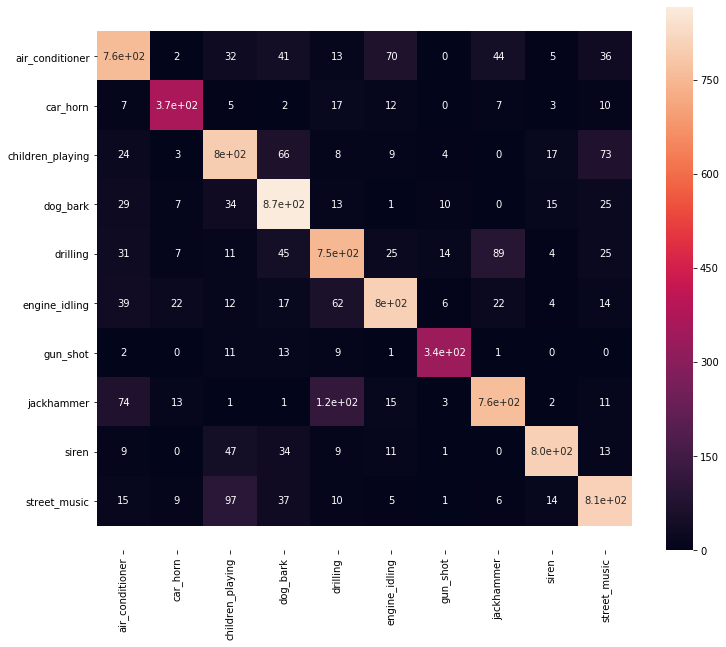

In [56]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [57]:
Table_model_4=table_maker(Fold_accuracy_4,end_array_4,Avg_Accuracy_4,Time_4)

  Fold  Accuracy  Time Taken
0    1  0.723049     77.9157
1    2  0.904171     82.4810
2    3  0.933798     79.5917
3    4  0.946078     81.1653
4    5  0.956042     79.4659
5    6  0.961798     78.0084
6    7  0.967895     83.4365
7    8  0.971216     78.5276
8    9  0.974442     32.4043
9   10  0.975797     32.9137

    Average Accuracy  Total Time
0          0.931429    705.9101


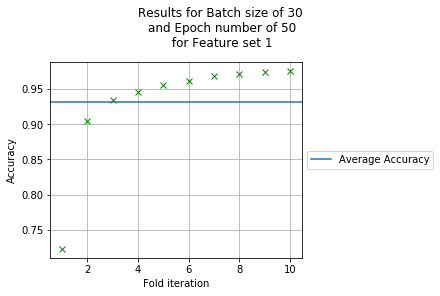

In [58]:
Graph_Avg_model_4=Graph_Avg_maker(Fold_accuracy_4,Avg_Accuracy_4)

In [59]:
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

Epoch_number=30
cnn_model_4_history = model_4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_4_no_cross=model_4.evaluate(X_test, y_test)
accuracy_model_4_no_cross = score_model_4_no_cross[1]
print(f"\nAccuracy of model 4 with no cross validation: {round(accuracy_model_4_no_cross,4)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 0s - loss: 3.0700e-05 - accuracy: 1.00 - ETA: 0s - loss: 0.0804 - accuracy: 0.9826   - ETA: 0s - loss: 0.1339 - accuracy: 0.98 - ETA: 0s - loss: 0.1274 - accuracy: 0.98 - ETA: 0s - loss: 0.1321 - accuracy: 0.98 - ETA: 0s - loss: 0.1172 - accuracy: 0.98 - ETA: 0s - loss: 0.1001 - accuracy: 0.98 - ETA: 0s - loss: 0.0915 - accuracy: 0.98 - ETA: 0s - loss: 0.1176 - accuracy: 0.98 - ETA: 0s - loss: 0.1492 - accuracy: 0.98 - ETA: 0s - loss: 0.2030 - accuracy: 0.98 - ETA: 0s - loss: 0.2809 - accuracy: 0.98 - ETA: 0s - loss: 0.2900 - accuracy: 0.98 - ETA: 0s - loss: 0.2790 - accuracy: 0.98 - ETA: 0s - loss: 0.2688 - accuracy: 0.98 - 1s 100us/step - loss: 0.2691 - accuracy: 0.9799 - val_loss: 2.1025 - val_accuracy: 0.9044
Epoch 2/30
7895/7895 [==============================] - ETA: 23s - loss: 0.0000e+00 - accuracy: 1.000 - ETA: 1s - loss: 0.1439 - accuracy: 0.9908    - ETA: 1s - loss: 0.

## Model from Github

In [60]:
# Model from GitHub

#adding layers and forming the model

#forming model
model_5=Sequential()

model_5.add(Conv2D(64,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(24,4,1)))
model_5.add(MaxPooling2D(padding="same"))

model_5.add(Conv2D(128,kernel_size=5,strides=1,padding="same",activation="relu"))
model_5.add(MaxPooling2D(padding="same"))
model_5.add(Dropout(0.3))

model_5.add(Flatten())

model_5.add(Dense(256,activation="relu"))
model_5.add(Dropout(0.3))

model_5.add(Dense(512,activation="relu"))
model_5.add(Dropout(0.3))

model_5.add(Dense(10,activation="softmax"))

#compiling
Model_5=model_5.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [61]:
Accuracy_array_5=[]
accuracy_total_5=0
end_array_5=[]

Epoch_array_accuracy_5=[]
Loss_array_5=[]
Fold_accuracy_5=[]

Val_accuracy_array_5=[]
Val_Loss_array_5=[]

Avg_Accuracy_5=[]
Time_5=[]

accuracy_score=[]
Epoch_number=50
Batch_size=30

Confusion_Matrix_array = []
Metrics_f1 = []
Metrics_precision = []
Metrics_recall = []
Metrics_accuracy = []

Model_5=Model_run_nn_es_NO_EARLY_STOPPING(Model_5,model_5,X_folds_10,Y_folds_10,Accuracy_array_5,
                     accuracy_total_5,end_array_5,Epoch_array_accuracy_5,Loss_array_5,
                     Fold_accuracy_5,Val_accuracy_array_5,Val_Loss_array_5, Confusion_Matrix_array,
                     Metrics_f1, Metrics_precision, Metrics_recall, Metrics_accuracy)
Avg_Accuracy_5=Model_5[0]
Time_5=Model_5[1]


Fold #1
- - - - - - - - - - - - - - - - - - - -
(7859, 24, 4, 1) (7859, 10) (873, 24, 4, 1) (873, 10)


C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy of Fold 1 is 0.25755947828292847
Time to train Fold 1 : 209.8011 seconds.

Fold #2
- - - - - - - - - - - - - - - - - - - -
(7844, 24, 4, 1) (7844, 10) (888, 24, 4, 1) (888, 10)
Accuracy of Fold 2 is 0.11259306967258453
Time to train Fold 2 : 242.7312 seconds.

Fold #3
- - - - - - - - - - - - - - - - - - - -
(7807, 24, 4, 1) (7807, 10) (925, 24, 4, 1) (925, 10)
Accuracy of Fold 3 is 0.11081849783658981
Time to train Fold 3 : 243.4855 seconds.

Fold #4
- - - - - - - - - - - - - - - - - - - -
(7742, 24, 4, 1) (7742, 10) (990, 24, 4, 1) (990, 10)
Accuracy of Fold 4 is 0.11271248012781143
Time to train Fold 4 : 234.2439 seconds.

Fold #5
- - - - - - - - - - - - - - - - - - - -
(7796, 24, 4, 1) (7796, 10) (936, 24, 4, 1) (936, 10)
Accuracy of Fold 5 is 0.11103899031877518
Time to train Fold 5 : 241.5771 seconds.

Fold #6
- - - - - - - - - - - - - - - - - - - -
(7909, 24, 4, 1) (7909, 10) (823, 24, 4, 1) (823, 10)
Accuracy of Fold 6 is 0.11752939224243164
Time to train Fold 6 : 755.8

In [62]:
print('Fold No, F-measure, Precision, Recall, Accuracy')
for i in range(10):
    print(f'{i+1}, {Metrics_f1[i]}, {Metrics_precision[i]}, {Metrics_recall[i]}, {Metrics_accuracy[i]}')
#     print(i + Metrics_f1 + ' , 'Metrics_precision + ' , 'Metrics_recall + ' , 'Metrics_accuracy)

Fold No, F-measure, Precision, Recall, Accuracy
1, 0.02354522861828357, 0.013121138284988499, 0.1145475372279496, 0.1145475372279496
2, 0.02279607542765438, 0.012681600519438356, 0.11261261261261261, 0.11261261261261261
3, 0.02109426499670402, 0.01168736303871439, 0.10810810810810811, 0.10810810810810811
4, 0.01853396348809193, 0.010203040506070809, 0.10101010101010101, 0.10101010101010101
5, 0.020625020625020623, 0.011414274234787055, 0.10683760683760683, 0.10683760683760683
6, 0.012611602729059193, 0.006826815329035078, 0.08262454434993925, 0.08262454434993925
7, 0.015082278844597171, 0.008225061374678887, 0.09069212410501193, 0.09069212410501193
8, 0.017077798861480076, 0.009365244536940686, 0.0967741935483871, 0.0967741935483871
9, 0.018352329796060964, 0.010098279507881584, 0.10049019607843138, 0.10049019607843138
10, 0.02222222222222222, 0.012345679012345678, 0.1111111111111111, 0.1111111111111111


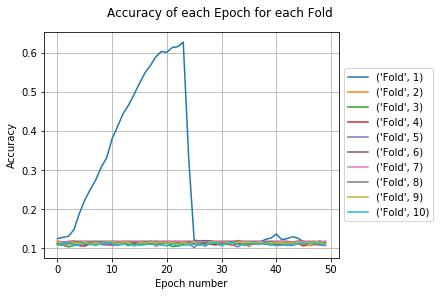

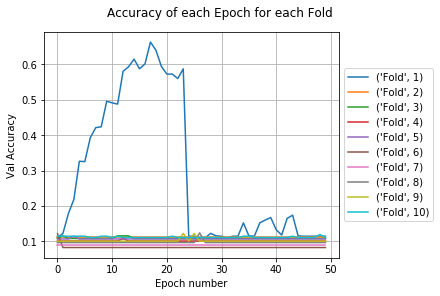

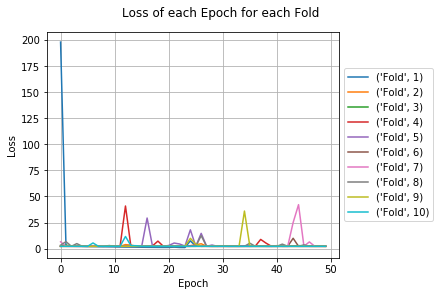

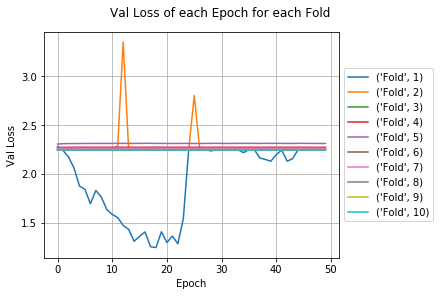

In [63]:
Graph_Epochs_model_5=Graph_func(Epoch_number,Epoch_array_accuracy_5,Val_accuracy_array_5,Loss_array_5,Val_Loss_array_5) 

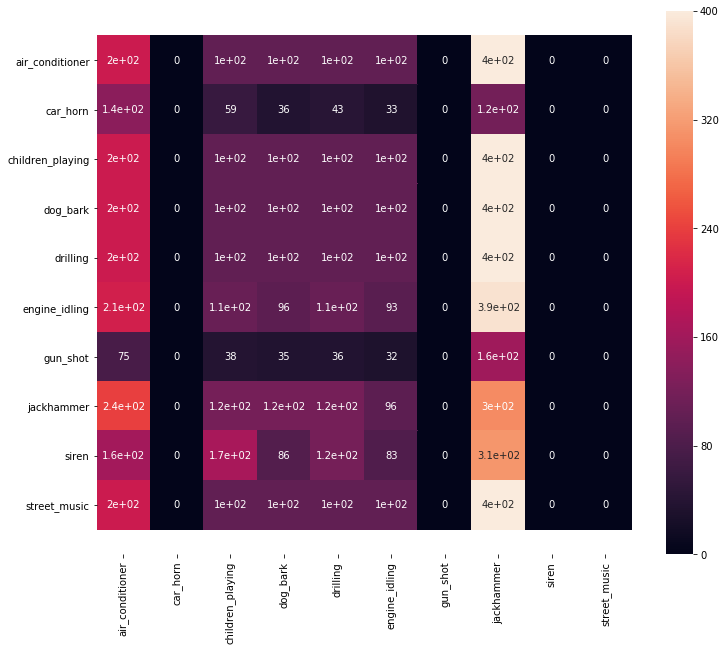

In [64]:
avg_cm = average_confusion_matrix(Confusion_Matrix_array)
plot_confusion_matrix(avg_cm)

In [65]:
Table_model_5=table_maker(Fold_accuracy_5,end_array_5,Avg_Accuracy_5,Time_5)

  Fold  Accuracy  Time Taken
0    1  0.257559    209.8011
1    2  0.112593    242.7312
2    3  0.110818    243.4855
3    4  0.112712    234.2439
4    5  0.111039    241.5771
5    6  0.117529    755.8079
6    7  0.116810    242.3684
7    8  0.115027    214.3525
8    9  0.113421    168.3596
9   10  0.110191    160.7982

    Average Accuracy  Total Time
0           0.12777   2713.5254


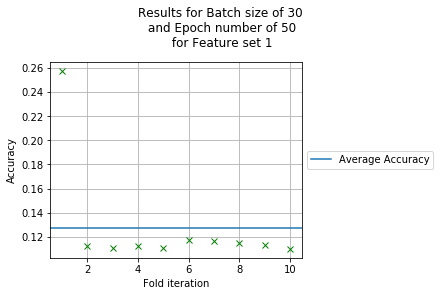

In [66]:
Graph_Avg_model_5=Graph_Avg_maker(Fold_accuracy_5,Avg_Accuracy_5)

### Github model with no cross validation

In [67]:
X_train = np.vstack([X_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
y_train = np.vstack([Y_folds_10[j] for j in range(0, len(Y_folds_10)-1)])
X_test = X_folds_10[9]
y_test = Y_folds_10[9]

Epoch_number=30
cnn_model_5_history = model_5.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=Epoch_number)
score_model_5_no_cross=model_5.evaluate(X_test, y_test)
accuracy_model_5_no_cross = score_model_5_no_cross[1]
print(f"\nAccuracy of model 5 with no cross validation: {round(accuracy_model_5_no_cross,4)}")

Train on 7895 samples, validate on 837 samples
Epoch 1/30
7895/7895 [==============================] - ETA: 3s - loss: 2.2348 - accuracy: 0.03 - ETA: 2s - loss: 2.2432 - accuracy: 0.09 - ETA: 2s - loss: 2.2660 - accuracy: 0.10 - ETA: 2s - loss: 2.2639 - accuracy: 0.10 - ETA: 2s - loss: 2.2557 - accuracy: 0.09 - ETA: 2s - loss: 2.2575 - accuracy: 0.10 - ETA: 2s - loss: 2.2583 - accuracy: 0.10 - ETA: 2s - loss: 2.2583 - accuracy: 0.11 - ETA: 2s - loss: 2.2562 - accuracy: 0.11 - ETA: 2s - loss: 2.2577 - accuracy: 0.11 - ETA: 2s - loss: 2.2573 - accuracy: 0.11 - ETA: 2s - loss: 2.2578 - accuracy: 0.11 - ETA: 2s - loss: 2.2593 - accuracy: 0.11 - ETA: 2s - loss: 2.2616 - accuracy: 0.11 - ETA: 1s - loss: 2.2618 - accuracy: 0.12 - ETA: 1s - loss: 2.2606 - accuracy: 0.12 - ETA: 1s - loss: 2.2596 - accuracy: 0.12 - ETA: 1s - loss: 2.2580 - accuracy: 0.12 - ETA: 1s - loss: 2.2582 - accuracy: 0.11 - ETA: 1s - loss: 2.2595 - accuracy: 0.11 - ETA: 1s - loss: 2.2600 - accuracy: 0.11 - ETA: 1s - loss:

### Model comparisson

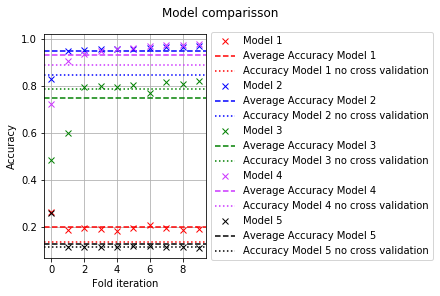

In [71]:
%matplotlib inline

 

fig, ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())

 

ax1.plot(Fold_accuracy,"rx",label="Model 1")
ax1.axhline(y=Avg_Accuracy,label='Average Accuracy Model 1',color='r',ls="--")
ax1.axhline(y=accuracy_model_1_no_cross,label='Accuracy Model 1 no cross validation',color='r',ls=":")

 


ax1.plot(Fold_accuracy_2,"bx",label="Model 2")
ax1.axhline(y=Avg_Accuracy_2,label='Average Accuracy Model 2',color='b',ls="--")
ax1.axhline(y=accuracy_model_2_no_cross,label='Accuracy Model 2 no cross validation',color='b',ls=":")

 


ax1.plot(Fold_accuracy_3,"gx",label="Model 3")
ax1.axhline(y=Avg_Accuracy_3,label='Average Accuracy Model 3',color='g',ls="--")
ax1.axhline(y=accuracy_model_3_no_cross,label='Accuracy Model 3 no cross validation',color='g',ls=":")

 

ax1.plot(Fold_accuracy_4,"x", color="#cc33ff",label="Model 4")
ax1.axhline(y=Avg_Accuracy_4,label='Average Accuracy Model 4',color='#cc33ff',ls="--")
ax1.axhline(y=accuracy_model_4_no_cross,label='Accuracy Model 4 no cross validation',color='#cc33ff',ls=":")

 

ax1.plot(Fold_accuracy_5,"kx",label="Model 5")
ax1.axhline(y=Avg_Accuracy_5,label='Average Accuracy Model 5',color='k',ls="--")
ax1.axhline(y=accuracy_model_5_no_cross,label='Accuracy Model 5 no cross validation',color='k',ls=":")

 

#ax1.set_title('Results for a batch size of',Batch_size,'and',Epoch_number,'.')
fig.suptitle(f"Model comparisson")
ax1.set_xlabel("Fold iteration")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [1]:
Val_accuracy_array_fix = [Val_accuracy_array[i][-1] for i in range(10)]
Val_accuracy_array_2_fix = [Val_accuracy_array_2[i][-1] for i in range(10)]
Val_accuracy_array_3_fix = [Val_accuracy_array_3[i][-1] for i in range(10)]
Val_accuracy_array_4_fix = [Val_accuracy_array_4[i][-1] for i in range(10)]
Val_accuracy_array_5_fix = [Val_accuracy_array_5[i][-1] for i in range(10)]

%matplotlib inline

fig, ax1 = plt.subplots(1, 1, constrained_layout=True, subplot_kw=dict())

ax1.plot(Val_accuracy_array_fix,"rx",label="Model 1")
ax1.axhline(y=np.average(Val_accuracy_array_fix),label='Average Accuracy Model 1',color='r',ls="--")
ax1.axhline(y=accuracy_model_1_no_cross,label='Accuracy Model 1 no cross validation',color='r',ls=":")


ax1.plot(Val_accuracy_array_2_fix,"bx",label="Model 2")
ax1.axhline(y=np.average(Val_accuracy_array_2_fix),label='Average Accuracy Model 2',color='b',ls="--")
ax1.axhline(y=accuracy_model_2_no_cross,label='Accuracy Model 2 no cross validation',color='b',ls=":")


ax1.plot(Val_accuracy_array_3_fix,"gx",label="Model 3")
ax1.axhline(y=np.average(Val_accuracy_array_3_fix),label='Average Accuracy Model 3',color='g',ls="--")
ax1.axhline(y=accuracy_model_3_no_cross,label='Accuracy Model 3 no cross validation',color='g',ls=":")

ax1.plot(Val_accuracy_array_4_fix,"x", color="#cc33ff",label="Model 4")
ax1.axhline(y=np.average(Val_accuracy_array_4_fix),label='Average Accuracy Model 4',color='#cc33ff',ls="--")
ax1.axhline(y=accuracy_model_4_no_cross,label='Accuracy Model 4 no cross validation',color='#cc33ff',ls=":")

ax1.plot(Val_accuracy_array_5_fix,"kx",label="Model 5")
ax1.axhline(y=np.average(Val_accuracy_array_5_fix),label='Average Accuracy Model 5',color='k',ls="--")
ax1.axhline(y=accuracy_model_5_no_cross,label='Accuracy Model 5 no cross validation',color='k',ls=":")

#ax1.set_title('Results for a batch size of',Batch_size,'and',Epoch_number,'.')
fig.suptitle(f"Model comparisson")
ax1.set_xlabel("Fold iteration")
ax1.set_ylabel("Accuracy")
ax1.grid()
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

NameError: name 'Val_accuracy_array' is not defined

## Logistic Regression

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_folds, Y_folds = data_processor_log_reg(X_folds,Y_folds)

X_train = np.vstack([X_folds[j] for j in range(0, len(Y_folds)-1)])
y_train = np.vstack([Y_folds[j] for j in range(0, len(Y_folds)-1)])
X_test = X_folds[9]
y_test = Y_folds[9]

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\tomna\Untitled Folder\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy of logistic regression classifier on test set: 0.66
